# Find dams using WOFLs

**What does this notebook do?** This notebook uses `wofs_albers` tiles (aka `WOFLs`) to identify water bodies in the landscape. This code follows the following workflow:
* Select a time period and location for the analysis
* Extract all available WOFLs for that time and location
* Calculate the percentage of time each pixel is observed as wet
* Keep only pixels identified as wet at least 5% of the time
* Convert the raster data into polygons
* Filter the polygons based on size and proximity to identified major rivers
* Write out the final polygon set as a shapefile

**Requirements:**
You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This example also uses a number of functions available within the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Author:** Claire Krause

In [23]:
# %pylab notebook

from datacube import Datacube
from datacube.storage import masking
import rasterio.features
from shapely.geometry import Polygon, shape
import geopandas as gp
from descartes import PolygonPatch
import fiona
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from datacube.helpers import write_geotiff

# Import the custom scripts. These can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append('../10_Scripts')
import water_classifier_and_wofs

dc = Datacube(app='pixel_drill')

## Set up the analysis

### Select a cropping season and test location

In [4]:
query = {'lat': (-30.310464, -30.748712),
         'lon': (149.681035, 150.169855),
         'time':('2016-10-01', '2017-05-01')
         }

### Set up some file names for the outputs we will write

In [5]:
# The name and filepath of the intermediate GeoTIFF file
WOFS_TIFF = 'wofs.tif'

# The name and filepath of the final output polygon set
WOFSshp = 'wofs.shp'

## Load the WOFLs

In [6]:
%%time
WOFL = dc.load(product='wofs_albers', **query)

CPU times: user 7.99 s, sys: 1.01 s, total: 9 s
Wall time: 22.9 s


## Identify the water bodies in our study area during our chosen time period

We are only interested in the water classifier, so we will create a boolean mask for wet vs not wet. This way we can easily find dams from always dry ground.

In [35]:
wetWOFL = masking.make_mask(WOFL, wet = True)
dryWOFL = masking.make_mask(WOFL, dry = True)

### Calculate percentage wet over this season
We want to work out how often a pixel is wet, as a proportion of the total time the pixel was observed.

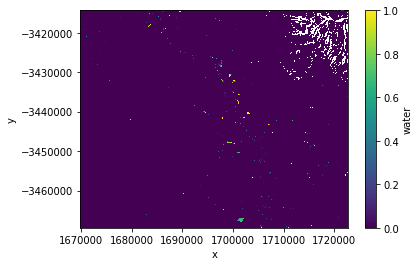

In [36]:
total_water_obs = wetWOFL.water.sum(dim='time')
total_dry_obs = dryWOFL.water.sum(dim='time')

wofs = (total_water_obs / (total_water_obs + total_dry_obs)) 
wofs.plot() 

### Write out our percentage wet classification to .TIFF
(So we can refer to it later on if required)

In [37]:
wofsds = wofs.to_dataset()
wofsds.attrs['affine'] = WOFL.affine
wofsds.attrs['crs'] = WOFL.crs
write_geotiff(WOFS_TIFF, wofsds)

## Filter our classified data layer to remove noise

### First, filter the raster based on values >0.05
I.e. where water is observed at least 5% of the time (to remove e.g. ponds of water after rain events). This removes much of the noise from our dataset. We also convert our classifier into a boolean dataset here, to remove the seasonal percentage values for each pixel and just keep the 'yes'/'no' 'could it be a dam' information.

In [38]:
WOFSfiltered = wofs > 0.05

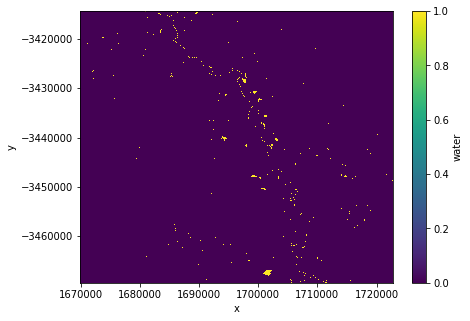

In [39]:
fig = plt.figure(figsize=(7, 5))
WOFSfiltered.plot()

## Convert the raster to polygons

At this point, we want to move from a gridded dataset to polygons, so we can treat the clusers of wet pixels as a whole.

In [25]:
WOFSpolygons = rasterio.features.shapes(WOFSfiltered.data.astype('float32'), transform = WOFL.affine)
WOFSlist = list(WOFSpolygons)

## Filter the wet polygons to find 'dams'
Note that these are 'dams' because we can not definitively say whether the water bodies identified are farm storages, lakes, rivers, or any other type of persistent water body. 

We can filter our identified water bodies to get us closer to dams though...

### Remove the giant zero polygon

When we convert our data into polygons, the area surrounding the water features we want to capture is also converted to a polygon. We need to filter out any polygon that was created from the areas not identified as wet.

In [26]:
RemoveZero = [i for i, x in enumerate(WOFSlist) if x[1] == 1]
RemoveZeroWOFS = [WOFSlist[x] for x in RemoveZero]

### Calculate the area of each polygon

In [27]:
WOFLshapes = []
for i, WOFLshape in enumerate(RemoveZeroWOFS):
    polyArea = Polygon(WOFLshape[0]['coordinates'][0]).area
    WOFLshape[0]['properties'] = {'area': polyArea}
    WOFLshapes.append(WOFLshape)

### Filter out any polygons smaller than 5000 m2

This value can be changed, however we have set it at 5000 m2 to focus only on large water bodies for now.

In [28]:
AreasIndex = [i for i, x in enumerate(WOFLshapes) if x[0]['properties']['area'] > 5050]
WOFSOFSbig = [WOFLshapes[x] for x in AreasIndex]

### Remove any polygons that intersect with a major river

We are only interested in farm dams, so do not need the WOFS polygons for the rivers. We use the [surface hydrology lines dataset](http://pid.geoscience.gov.au/dataset/ga/83107) to filter out polygons that intersect with major rivers. Note that we have filtered this dataset to only keep rivers tagged as `major`, and it is this filtered dataset that we use here.

In [29]:
MajorRivers = gp.GeoDataFrame.from_file('/g/data/r78/cek156/ShapeFiles/SurfaceHydrologyLinesRegionalFilteredMAJOR.shp') 

In [30]:
WOFSOFSbreaktuple = [a for a, b in list(WOFSOFSbig)]

# Grab the geometeries
for poly in WOFSOFSbreaktuple:
    poly['geometry'] = shape(poly)
    
WOFSOFSfiltered2p0 = gp.GeoDataFrame(WOFSOFSbreaktuple).set_geometry('geometry')
Intersections= gp.sjoin(MajorRivers, WOFSOFSfiltered2p0, how="inner", op='intersects')
IntersectIndex = sorted(list(set(Intersections['index_right'])))

WOFSOFS = [WOFSOFSbreaktuple[x] for x in range(len(WOFSOFSbreaktuple)) 
                                  if x not in IntersectIndex]

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/geopandas/tools/sjoin.py:53: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


## Plot the final set of dam polygons

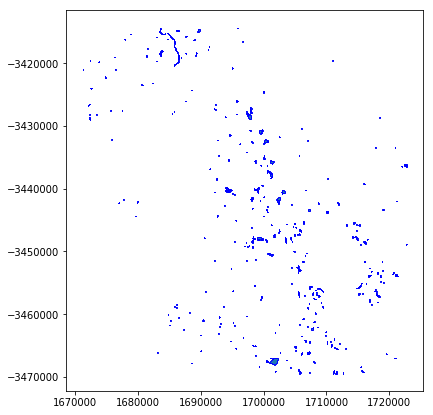

In [31]:
fig = plt.figure(figsize = [7,7])
ax = fig.gca()
for i in range(len(WOFSOFS)):
    ax.add_patch(PolygonPatch(WOFSOFS[i], edgecolor = 'b', facecolor = None))
ax.axis('scaled')
plt.draw()
plt.show()

## Save the polygons to a shapefile

In [32]:
schema = {'geometry': 'Polygon','properties': {'area': 'str'}}

with fiona.open(WOFSshp, "w", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
    for i in range(len(WOFSOFS)):
        output.write({'properties': {'area': WOFSOFS[i]['properties']['area']},
                    'geometry': {'type': WOFSOFS[i]['type'], 'coordinates': WOFSOFS[i]['coordinates']}})